
## Entrenamiento de los modelos

In [14]:
import json
import pickle
import numpy as np
import logging
import os
import warnings
import joblib
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             precision_score, recall_score, roc_auc_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

In [50]:
data = pd.read_csv("D:/Repositorio\Proyecto_ Venta de autos/Data_procecced/data_clean.csv")
data.head(3)

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,1,35,20000,0
1,681,1,40,43500,0
2,353,1,49,74000,0


In [62]:
features = data.drop(columns=['Purchased'])  # Eliminar la columna de destino
target = data['Purchased']  # Guardar la columna de destino

# Escalar las características
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convertir los resultados escalados a un DataFrame con los mismos nombres de columnas
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Combinar las características escaladas con la columna de destino
df_scaled = pd.concat([scaled_features_df, target], axis=1)


In [63]:
df_scaled.head(3)

,User ID,Gender,Age,AnnualSalary,Purchased
0,-0.400104,1.032529,-0.477120,-1.528498,0
1,0.625271,1.032529,-0.009905,-0.846767,0
2,-0.510955,1.032529,0.831082,0.038032,0


Realizaremos dos entrenamientos, uno sin aplicar escalamiento y otro aplicando escalamiento

In [5]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Venta de autos training")

2024/08/27 15:55:18 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/08/27 15:55:18 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///d:/Repositorio/Proyecto_ Venta de autos/mlruns/1', creation_time=1724788519324, experiment_id='1', last_update_time=1724788519324, lifecycle_stage='active', name='Venta de autos training', tags={}>

In [49]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Venta de autos training_2")

2024/08/27 18:13:45 INFO mlflow.tracking.fluent: Experiment with name 'Venta de autos training_2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Repositorio/Proyecto_ Venta de autos/mlruns/2', creation_time=1724796825778, experiment_id='2', last_update_time=1724796825778, lifecycle_stage='active', name='Venta de autos training_2', tags={}>

In [57]:
def data_transform(df: pd.DataFrame):
    #Thhis function transform the data into X and y
    X = df.drop(["Purchased","User ID"], axis=1)
    y = df.Purchased
    return X, y


def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    filepath = os.path.join("D:/Repositorio/Proyecto_ Venta de autos", "Data_procecced", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
        
def split_train_test(
    X: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    This function splits the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
    Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train.values, y_test.values

def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
      model (object): model
      name_model (str): name of the model
      developer (str): developer name
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
     Returns:
      metric (list): list with the metrics"""
    
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba[:,1], average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba[:,1], average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info("ROC AUC Score Train: %.2f", roc_auc_score_train)
        logger.info("ROC AUC Score Test: %.2f", roc_auc_score_test)

        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )
        mlflow.log_metric("Train Accuracy", acc_score_train)
        mlflow.log_metric("Test Accuracy", acc_score_test)
        mlflow.log_metric("F-score_train", fscore_train)
        mlflow.log_metric("F-score_test", fscore_test)
        
        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(8, 4))


        cm = confusion_matrix(y_test, y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric
    
    
def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search

def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

In [64]:
X,y = data_transform(df_scaled)
X_train, X_test, y_train, y_test = split_train_test(X, y)

print(data.shape)
print(X.shape)
print(y.shape)
print(f"X_train{X_train.shape},X_test{X_test.shape}")
print(F"Y_train{y_train.shape}----Y_test{y_test.shape}")

(1000, 5)
(1000, 3)
(1000,)
X_train(700, 3),X_test(300, 3)
Y_train(700,)----Y_test(300,)


#### Modelo de Regresion logistica

Train Accuracy:  0.83
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       426
           1       0.82      0.73      0.77       274

    accuracy                           0.83       700
   macro avg       0.83      0.81      0.82       700
weighted avg       0.83      0.83      0.83       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       172
           1       0.85      0.67      0.75       128

    accuracy                           0.81       300
   macro avg       0.82      0.79      0.80       300
weighted avg       0.82      0.81      0.81       300



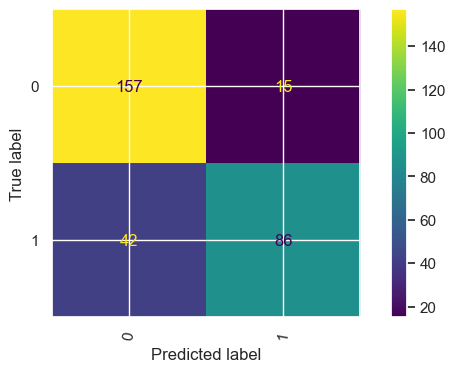

[0.92, 0.9, 0.83, 0.81, 0.83, 0.82, 0.83, 0.81, 0.83, 0.81]

In [65]:
log_reg = LogisticRegression(random_state=40)
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

#### Vayes

Train Accuracy:  0.88
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       426
           1       0.87      0.82      0.85       274

    accuracy                           0.88       700
   macro avg       0.88      0.87      0.88       700
weighted avg       0.88      0.88      0.88       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       172
           1       0.89      0.77      0.83       128

    accuracy                           0.86       300
   macro avg       0.87      0.85      0.86       300
weighted avg       0.87      0.86      0.86       300



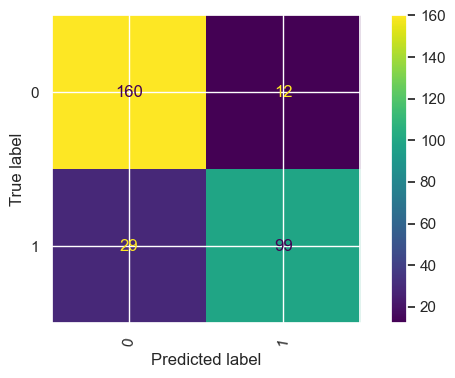

[0.95, 0.94, 0.88, 0.86, 0.88, 0.87, 0.88, 0.86, 0.88, 0.86]

In [66]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
display_classification_report(model=gnb, 
                              name_model="GaussianNB", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Modelo Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Decision tree Clasifier

Train Accuracy:  0.99
Test Accuracy:  0.89
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       426
           1       1.00      0.99      0.99       274

    accuracy                           0.99       700
   macro avg       1.00      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       172
           1       0.94      0.79      0.86       128

    accuracy                           0.89       300
   macro avg       0.90      0.87      0.88       300
weighted avg       0.89      0.89      0.88       300



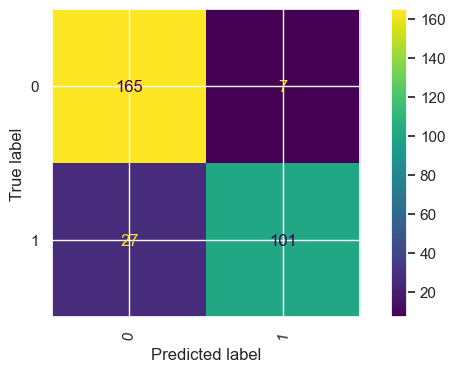

[1.0, 0.88, 0.99, 0.89, 0.99, 0.89, 0.99, 0.89, 0.99, 0.88]

In [68]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
display_classification_report(model=dtc, 
                              name_model="DecisionTreeClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Suport Vector Machine

Train Accuracy:  0.91
Test Accuracy:  0.9
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       426
           1       0.85      0.92      0.88       274

    accuracy                           0.91       700
   macro avg       0.90      0.91      0.90       700
weighted avg       0.91      0.91      0.91       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       172
           1       0.88      0.88      0.88       128

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



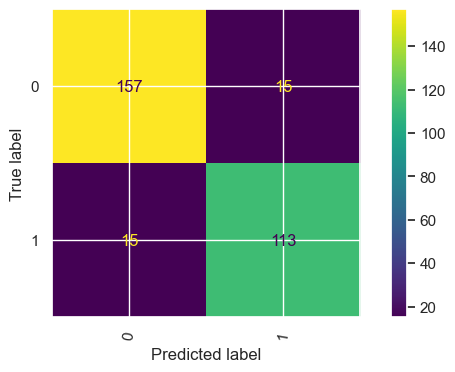

[0.96, 0.95, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9]

In [69]:
svc = SVC(gamma="auto", probability=True, random_state=42)
svc.fit(X_train, y_train)
display_classification_report(model=svc, 
                              name_model="SVC", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Ramdon Forest

Train Accuracy:  0.91
Test Accuracy:  0.89
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       426
           1       0.85      0.94      0.89       274

    accuracy                           0.91       700
   macro avg       0.90      0.92      0.91       700
weighted avg       0.92      0.91      0.91       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       172
           1       0.88      0.86      0.87       128

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



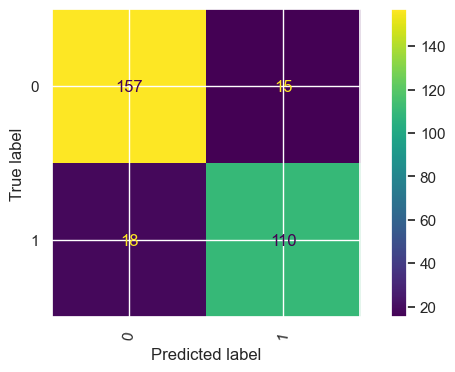

[0.94, 0.93, 0.91, 0.89, 0.92, 0.89, 0.91, 0.89, 0.91, 0.89]

In [70]:
rf = RandomForestClassifier(max_depth=2,random_state=42)
rf.fit(X_train, y_train)
display_classification_report(model= rf,
                              name_model="RandomForestClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### xGbOST

Train Accuracy:  0.99
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       426
           1       0.99      0.98      0.99       274

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       172
           1       0.87      0.84      0.85       128

    accuracy                           0.88       300
   macro avg       0.88      0.87      0.87       300
weighted avg       0.88      0.88      0.88       300



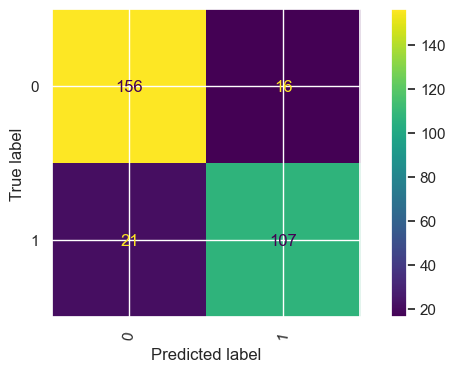

[1.0, 0.96, 0.99, 0.88, 0.99, 0.88, 0.99, 0.88, 0.99, 0.88]

In [71]:
xbc = XGBClassifier()
xbc.fit(X_train, y_train)
display_classification_report(model= xbc,
                              name_model="XGBClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### KNN

Train Accuracy:  0.93
Test Accuracy:  0.91
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       426
           1       0.90      0.93      0.91       274

    accuracy                           0.93       700
   macro avg       0.92      0.93      0.93       700
weighted avg       0.93      0.93      0.93       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       172
           1       0.90      0.88      0.89       128

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



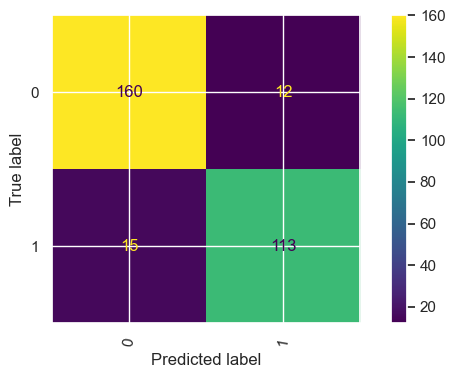

[0.99, 0.96, 0.93, 0.91, 0.93, 0.91, 0.93, 0.91, 0.93, 0.91]

In [72]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
display_classification_report(model= knn,
                              name_model="KNNClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Modelo de regresion logistica con GridSearchCV

In [73]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best Score:  0.8442857142857143
Best Hyperparameters:  {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001, 'warm_start': True}
Train Accuracy:  0.85
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       426
           1       0.79      0.83      0.81       274

    accuracy                           0.85       700
   macro avg       0.84      0.84      0.84       700
weighted avg       0.85      0.85      0.85       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       172
           1       0.77      0.77      0.77       128

    accuracy                           0.81       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.81

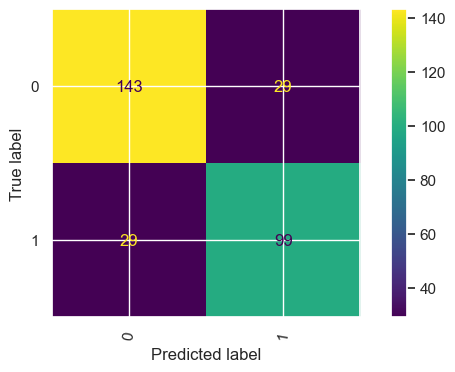

[0.92, 0.9, 0.85, 0.81, 0.85, 0.81, 0.85, 0.81, 0.85, 0.81]

In [74]:
log_reg = LogisticRegression()

params_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False],
    'warm_start': [True, False]
}


grid_search_log = grid_search(log_reg, folds, params_grid, scoring="accuracy")
grid_search_log.fit(X_train, y_train)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Jose Luis", 
                              X_train=X_train,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

#### Modelo Multinomial bayes con gridSearchCv

In [ ]:
mnb = MultinomialNB()
params_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Parámetro de suavizado de Laplace
    'fit_prior': [True, False],  # Si se debe aprender o no las probabilidades a priori de clase
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7]]  # Probabilidades a priori de clase
}
grid_search_mnb = grid_search(mnb, folds, params_grid, scoring="accuracy")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model= grid_search_mnb,
                              name_model="MultinomialNBCV",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Vayes con GridSearch

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.8714285714285713
Best Hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Train Accuracy:  0.88
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       426
           1       0.87      0.82      0.85       274

    accuracy                           0.88       700
   macro avg       0.88      0.87      0.88       700
weighted avg       0.88      0.88      0.88       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       172
           1       0.89      0.77      0.83       128

    accuracy                           0.86       300
   macro avg       0.87      0.85      0.86       300
weighted avg       0.87      0.86      0.86       300



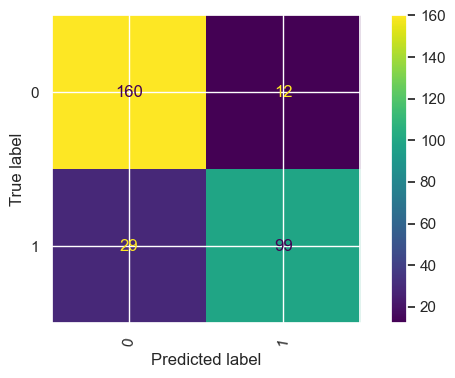

[0.95, 0.94, 0.88, 0.86, 0.88, 0.87, 0.88, 0.86, 0.88, 0.86]

In [76]:
gnvgb = GaussianNB()
params_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6],  # Ajuste para mejorar la estabilidad numérica
    'priors': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7]]  # Probabilidades a priori ajustadas
}
grid_search_mnb = grid_search(gnvgb, folds, params_grid, scoring="accuracy")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model= grid_search_mnb,
                              name_model="GAUSIANNBGS",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Decision Tree Clasifier con GridSearchCV

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
Best Score:  0.9099999999999999
Best Hyperparameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': None, 'splitter': 'best'}
Train Accuracy:  0.91
Test Accuracy:  0.91
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       426
           1       0.84      0.95      0.90       274

    accuracy                           0.91       700
   macro avg       0.91      0.92      0.91       700
weighted avg       0.92      0.91      0.91       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       172
           1       0.87      0.92      0.90       128

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91 

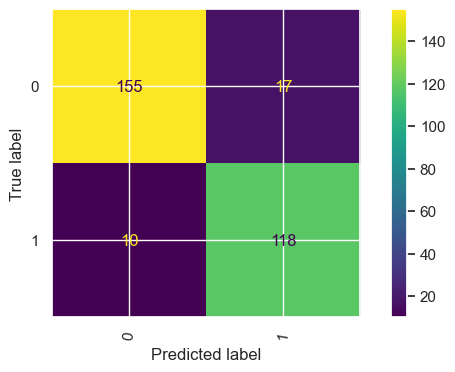

[0.98, 0.96, 0.91, 0.91, 0.92, 0.91, 0.91, 0.91, 0.91, 0.91]

In [26]:
dtc = DecisionTreeClassifier()
params_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Criterio para medir la calidad de una división
    'splitter': ['best', 'random'],  # Estrategia utilizada para elegir la división en cada nodo
    'max_depth': [None, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas para estar en un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'random_state': [None, 42],  # Controla la aleatoriedad del estimador
    'class_weight': [None, 'balanced'] # Pesos asociados con las clases
}
grid_search_dtc = grid_search(dtc,folds, params_grid, scoring=("accuracy"))
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(model= grid_search_dtc,
                              name_model="DecisionTreeClassifierCV",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Suport Vector Machine con GridSearchCV

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best Score:  0.7699999999999999
Best Hyperparameters:  {'C': 1.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 200, 'shrinking': True, 'tol': 0.001}
Train Accuracy:  0.78
Test Accuracy:  0.75
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.75      0.94      0.84       426
           1       0.85      0.51      0.64       274

    accuracy                           0.78       700
   macro avg       0.80      0.73      0.74       700
weighted avg       0.79      0.78      0.76       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.71      0.97      0.82       172
           1       0.91      0.47      0.62       128

    accuracy                           0.75       300
   macro avg       0.81      0.72      0.72       300
weighted avg     

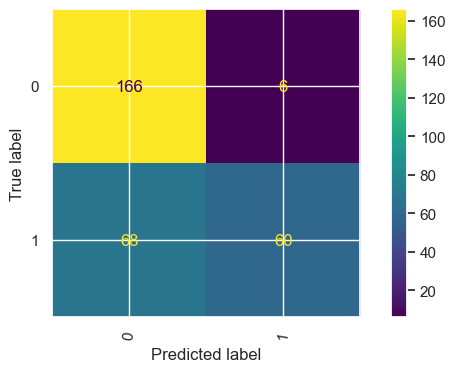

[0.69, 0.68, 0.78, 0.75, 0.79, 0.79, 0.78, 0.75, 0.76, 0.73]

In [27]:
svc = SVC(probability=True)

params_grid = {
    'C': [0.1, 1.0, 10.0],  # Parámetro de regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto', 0.1, 0.01],  # Coeficiente del kernel
    'shrinking': [True, False],  # Si usar la heurística de reducción
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerancia para el criterio de detención
    'class_weight': [None, 'balanced', {0: 1, 1: 5}],  # Pesos asociados con las clases
    'max_iter': [100, 200, 300],  # Límite de iteraciones dentro del solucionador
    'decision_function_shape': ['ovo', 'ovr'],  # Formato de la función de decisión
}
grid_search_svc = grid_search(svc, folds, params_grid, scoring= "accuracy")
grid_search_svc.fit(X_train, y_train)
print_best_score_params(grid_search_svc)

display_classification_report(model=grid_search_svc,
                              name_model="SuportVectorMachineCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Random Forest con GridSearchCV

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Score:  0.9142857142857144
Best Hyperparameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1}
Train Accuracy:  0.94
Test Accuracy:  0.89
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       426
           1       0.89      0.97      0.93       274

    accuracy                           0.94       700
   macro avg       0.93      0.94      0.94       700
weighted avg       0.94      0.94      0.94       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       172
           1       0.90      0.84      0.87       128

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89    

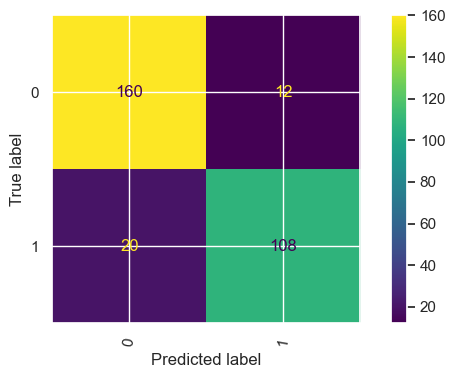

[0.99, 0.97, 0.94, 0.89, 0.94, 0.89, 0.94, 0.89, 0.94, 0.89]

In [28]:
rf = RandomForestClassifier()
params_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'class_weight': [None, 'balanced']
}
grid_search_rf = grid_search(rf, folds, params_grid, scoring= "accuracy")
grid_search_rf.fit(X_train, y_train)
print_best_score_params(grid_search_rf)
display_classification_report(model=grid_search_rf,
                              name_model="RandomForestClassifierCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo XGGBost con GridSearchCV

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Score:  0.9142857142857144
Best Hyperparameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1}
Train Accuracy:  0.99
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       426
           1       0.99      0.98      0.98       274

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       172
           1       0.88      0.83      0.85       128

    accuracy                           0.88       300
   macro avg       0.88      0.87      0.88    

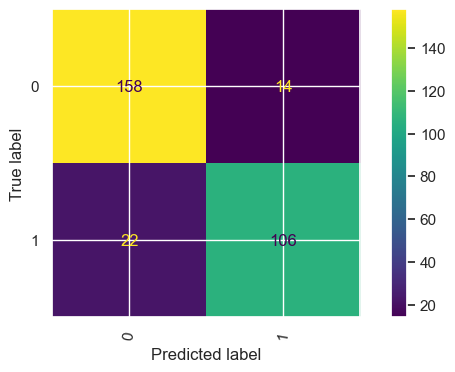

[1.0, 0.96, 0.99, 0.88, 0.99, 0.88, 0.99, 0.88, 0.99, 0.88]

In [29]:
xgbgb = XGBClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],      # Número de árboles
    'learning_rate': [0.01, 0.1, 0.3],   # Tasa de aprendizaje
    'max_depth': [3, 6, 9],              # Profundidad máxima de los árboles
    'subsample': [0.6, 0.8, 1.0]         # Proporción de muestras para cada árbol
}
grid_search_xg = grid_search(xgbgb, folds, params_grid, scoring= "accuracy")
grid_search_xg.fit(X_train, y_train)
print_best_score_params(grid_search_rf)
display_classification_report(model=grid_search_xg,
                              name_model="XGBClasifaterGB",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo KNN con GridSearchCV

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Score:  0.9142857142857144
Best Hyperparameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1}
Train Accuracy:  0.85
Test Accuracy:  0.79
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       426
           1       0.85      0.76      0.80       274

    accuracy                           0.85       700
   macro avg       0.85      0.84      0.84       700
weighted avg       0.85      0.85      0.85       700

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       172
           1       0.82      0.66      0.73       128

    accuracy                           0.79       300
   macro avg       0.80      0.78      0.78      

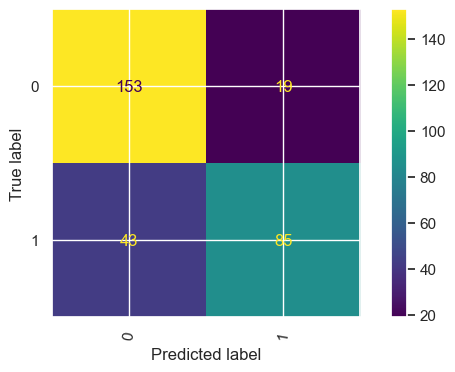

[0.92, 0.84, 0.85, 0.79, 0.85, 0.8, 0.85, 0.79, 0.85, 0.79]

In [32]:
kngv = KNeighborsClassifier()

param_gridj = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}
grid_search_kngb = grid_search(kngv, folds, param_gridj, scoring= "accuracy")
grid_search_kngb.fit(X_train, y_train)
print_best_score_params(grid_search_rf)
display_classification_report(model=grid_search_kngb,
                              name_model="KNNClassifierCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

PRIMERA RONDA DE ENTRENAMIENTO
Aqui escogeremos los 3 mejores modelos y trataremos de disminuir lasvaraibles y ver si se puede mejorar.

In [42]:
def evaluate_model_with_feature_selection(model, X_train, X_test, y_train, y_test):
    """
    Evalúa un modelo de clasificación entrenado utilizando diferentes subconjuntos de características y calcula la precisión (accuracy).
    
    Parámetros:
    - model: Un modelo de clasificación ya entrenado (por ejemplo, RandomForestClassifier, DecisionTreeClassifier).
    - X_train: Datos de entrenamiento (DataFrame o array-like).
    - X_test: Datos de prueba (DataFrame o array-like).
    - y_train: Etiquetas de entrenamiento.
    - y_test: Etiquetas de prueba.
    
    Devuelve:
    - None. La función imprime y grafica los resultados.
    """
    
    feature_names = np.array(X_train.columns)  # Convertir a array de numpy de los nombres de las características

    # Obtener importancias de las características del modelo ya entrenado
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    # Visualización del progreso
    num_features = []
    accuracies = []
    selected_features_dict = {}  # Diccionario para almacenar las características seleccionadas

    for i in range(1, len(importances) + 1):
        selected_indices = sorted_indices[:i]
        selected_columns = X_train.columns[selected_indices]  # Extraer nombres de las columnas seleccionadas

        X_train_selected = X_train[selected_columns]
        X_test_selected = X_test[selected_columns]

        # Entrenar un nuevo modelo con las características seleccionadas
        model_selected = model.__class__(**model.get_params())  # Crear una instancia del mismo tipo de modelo con los mismos parámetros
        model_selected.fit(X_train_selected, y_train)
        y_pred = model_selected.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)

        num_features.append(i)
        accuracies.append(accuracy)
        selected_features_dict[i] = feature_names[selected_indices]  # Guardar los nombres de las características seleccionadas

    # Graficar Accuracy vs. Número de características seleccionadas
    plt.figure(figsize=(8, 4))
    plt.plot(num_features, accuracies, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Features for Feature Selection')
    plt.grid(True)
    plt.show()

    # Mostrar características seleccionadas para un número específico de características
    num_selected = 3  # Cambia este valor para ver diferentes números de características seleccionadas
    print(f"Características seleccionadas para {num_selected} características:")
    print(selected_features_dict.get(num_selected, 'Número de características seleccionado no está en el rango.'))


In [ ]:
dtc_top1 = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=5,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=None,
    splitter='best'
)

dtc_top1.fit(X_train, y_train)

accuracy = dtc_top1.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9100


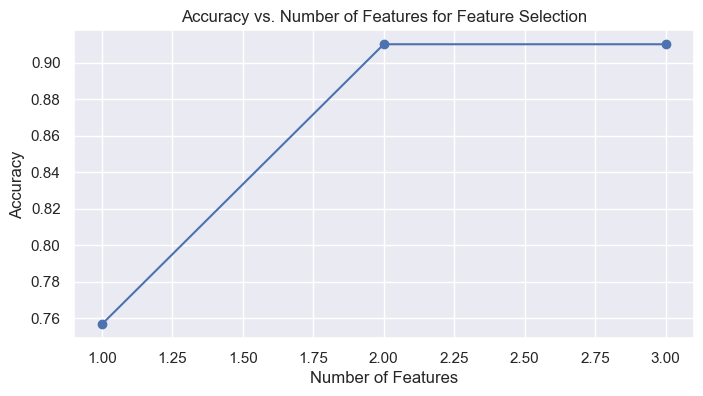

Características seleccionadas para 3 características:
['AnnualSalary' 'Age' 'Gender']


In [43]:
evaluate_model_with_feature_selection(dtc_top1, X_train, X_test, y_train, y_test)

In [45]:
rf_top2 = RandomForestClassifier(
    class_weight='balanced',  
    criterion='entropy',      
    max_depth=None, 
    max_features='sqrt',
    min_samples_leaf=2, 
    min_samples_split=10,
    n_estimators=200, 
    n_jobs=-1
)
rf_top2.fit(X_train, y_train)

accuracy = rf_top2.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9000


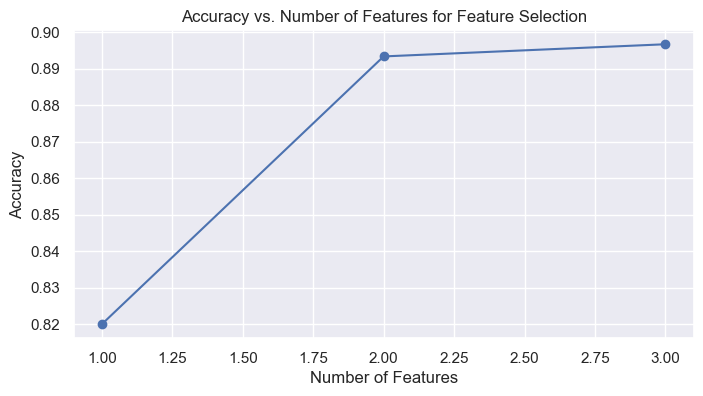

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [46]:
evaluate_model_with_feature_selection(rf_top2, X_train, X_test, y_train, y_test)

In [47]:
rf_top3 = RandomForestClassifier(max_depth=2,random_state=42)
rf_top3.fit(X_train, y_train)
accuracy = rf_top3.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.8900


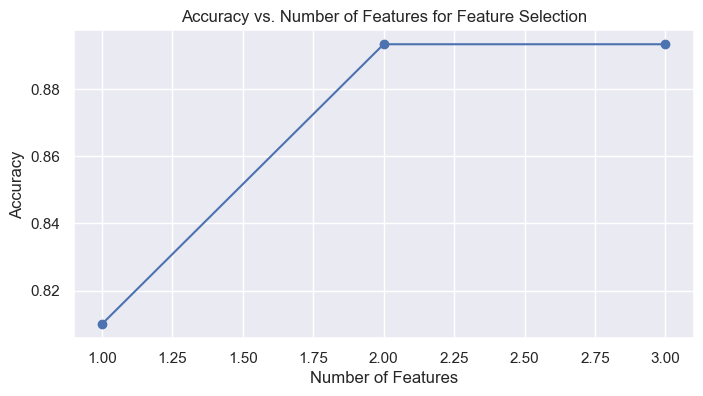

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [48]:
evaluate_model_with_feature_selection(rf_top3, X_train, X_test, y_train, y_test)

SEGUNDA RONDA DE ENTRENAMIENTO
Aqui escogeremos los 3 mejores modelos y trataremos de disminuir lasvaraibles y ver si se puede mejorar.